- https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB
-  

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ML_loader import DatasetLoader,ModelLoader


In [2]:
#Get data 
loader = DatasetLoader()
loader.read_dataset('./features_resnet.csv',class_path='labelsDefault.txt',separator=',')
#loader.read_dataset('./partial_database.csv',class_path='labelsDefault.txt',separator=',')
loader.add_dataset(file_path='./partial_database.csv')
loader.split_dataset()

#Normalize data, if not already normalized
print(np.shape(loader.X_train),np.shape(loader.X_test),np.shape(loader.y_train),np.shape(loader.y_test))

    AU01_r   AU02_r   AU04_r   AU05_r   AU06_r   AU07_r   AU09_r   AU10_r  \
0     0.00     0.00     0.28      0.0     0.31     1.19      0.0     0.26   
1     0.73     0.22     0.55      0.0     0.36     0.68      0.0     0.89   
2     0.66     0.22     1.48      0.0     0.45     0.44      0.0     0.81   
3     0.25     0.00     1.52      0.0     0.35     0.24      0.0     0.33   
4     0.00     0.00     1.71      0.0     0.24     0.31      0.0     0.36   

    AU12_r   AU14_r   AU15_r   AU17_r   AU20_r   AU23_r   AU25_r   AU26_r  \
0     0.10     0.00     0.71     0.89     0.00     0.00     0.00     0.82   
1     0.39     0.05     0.46     1.47     0.00     0.00     0.56     1.04   
2     0.36     0.07     0.22     2.36     0.11     0.51     0.56     1.25   
3     0.19     0.07     0.60     2.14     0.11     0.51     0.42     0.84   
4     0.25     0.02     0.38     1.89     0.11     0.51     0.05     0.58   

    AU45_r  
0     0.00  
1     0.17  
2     0.87  
3     0.87  
4     0.6

In [3]:
#Get model
model = ModelLoader()
model.set_model(MultinomialNB())

cv = RepeatedStratifiedKFold(n_splits=22, n_repeats=3, random_state=1)

#Optimization 
param = {'alpha': np.linspace(0.5, 1.5, 6),
            'fit_prior': [True, False]}

model.set_optimal_params(param)

model.optimize(loader.X_train,loader.y_train,cv=cv,scoring='accuracy',n_iter=10)

#Train model with optimal params
model.set_model(MultinomialNB(**model.optimal_params))


          0         1         2         3         4         5         6  \
0  0.058971  0.626277  0.107093  0.670639  0.685376  0.672881  0.541003   
1  0.293999  0.680076  0.070964  0.704674  0.800976  0.759914  0.789037   
2  0.026243  0.493064  0.071549  0.598101  0.668996  0.798525  0.383728   
3  0.264287  0.605679  0.043540  0.597128  0.845713  0.770380  0.757597   
4  0.049339  0.610061  0.145537  0.661091  0.692952  0.739890  0.485597   

          7         8         9  ...   AU12_r   AU14_r   AU15_r   AU17_r  \
0  0.021652  0.078406  0.713660  ...     0.10     0.00     0.71     0.89   
1  0.083484  0.022216  0.857469  ...     0.39     0.05     0.46     1.47   
2  0.031116  0.151202  0.682578  ...     0.36     0.07     0.22     2.36   
3  0.022491  0.014760  0.863484  ...     0.19     0.07     0.60     2.14   
4  0.096431  0.157701  0.787261  ...     0.25     0.02     0.38     1.89   

    AU20_r   AU23_r   AU25_r   AU26_r   AU45_r  class  
0     0.00     0.00     0.00     0.8

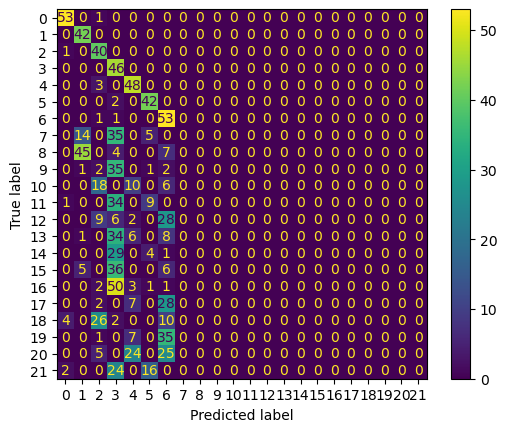

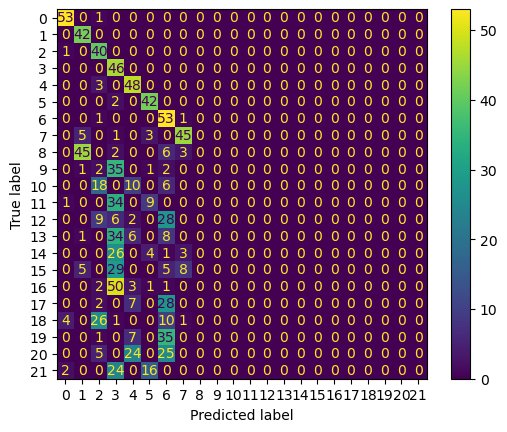

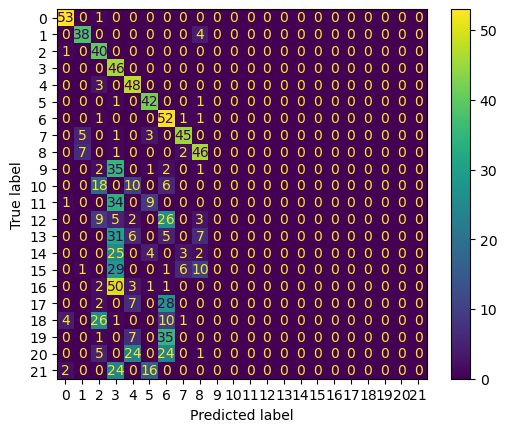

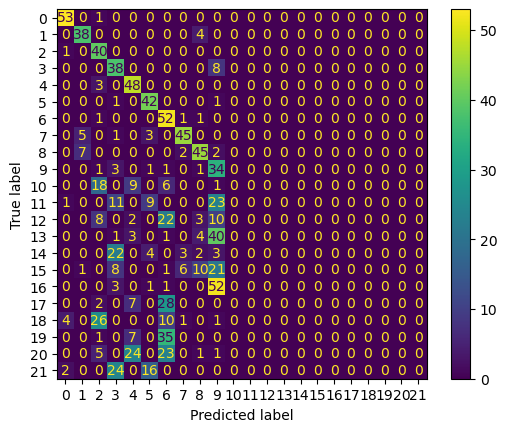

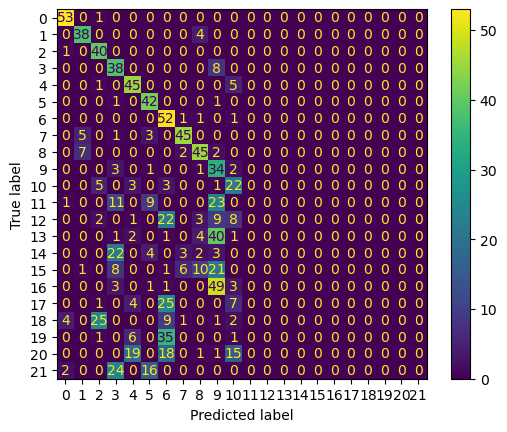

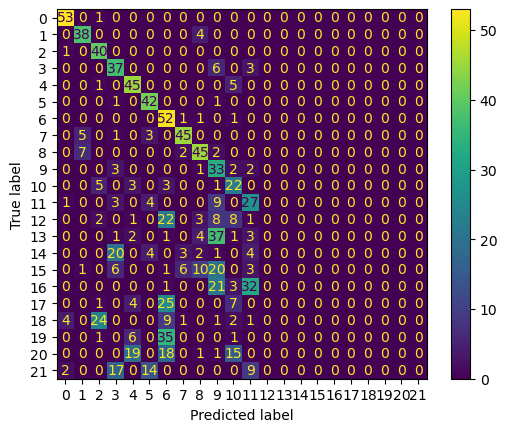

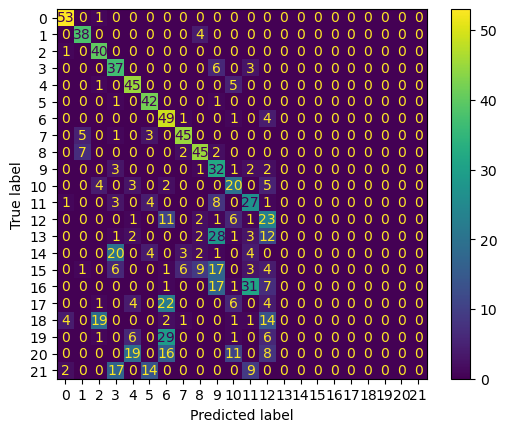

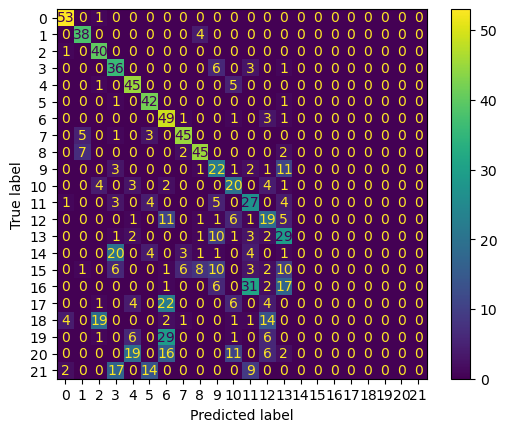

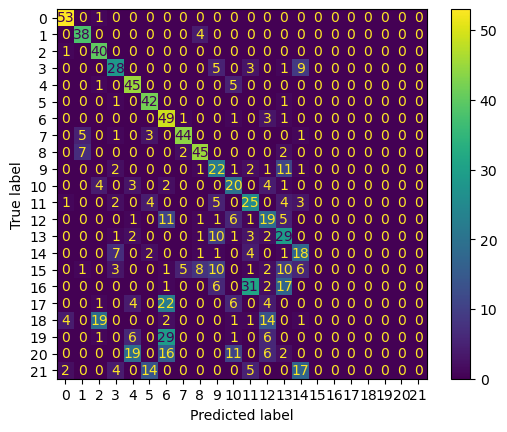

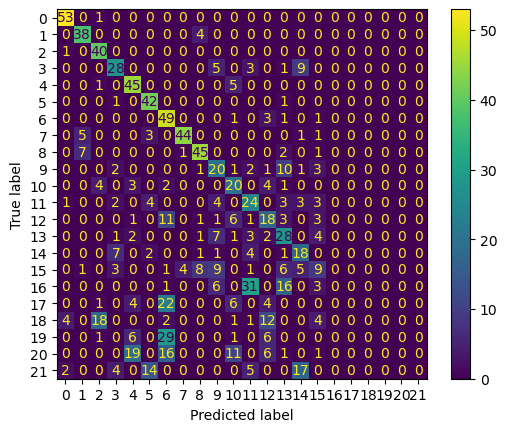

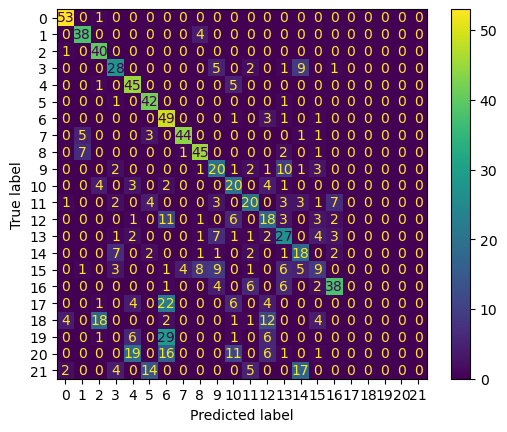

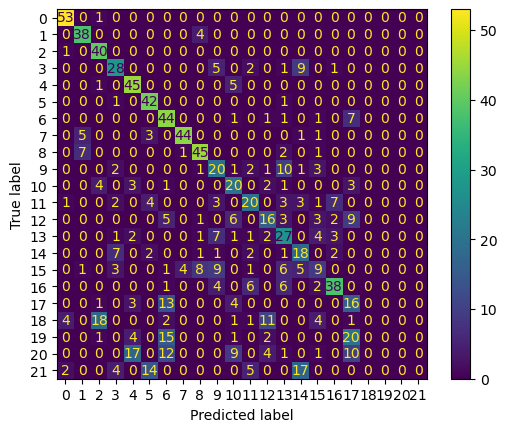

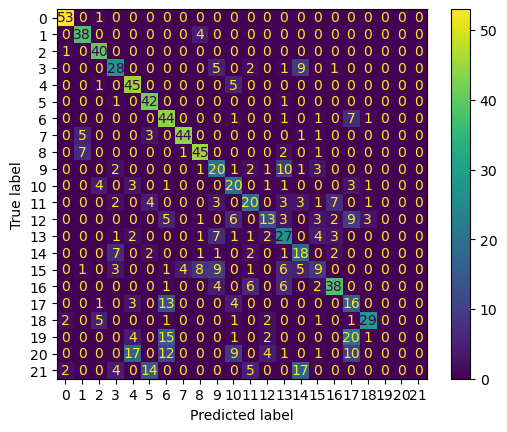

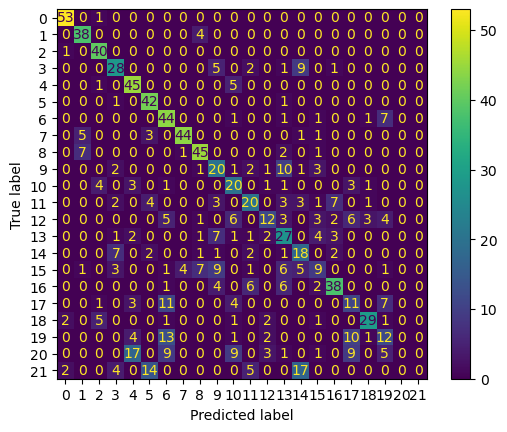

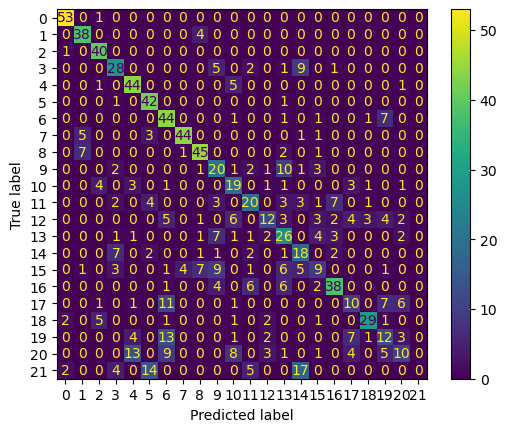

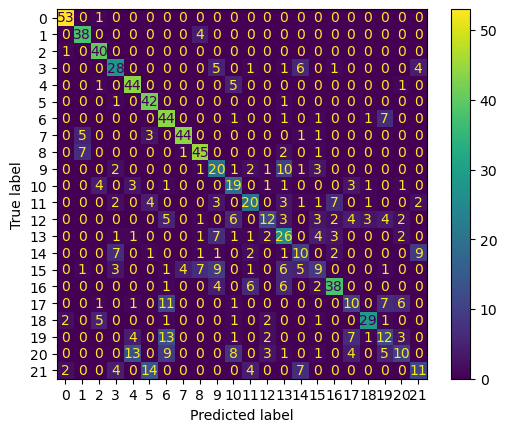

In [4]:
##Split by class, to increment by class:
class_to_group = {1:[1,2,3,4,5,6,7], 2:[8], 3:[9], 4:[10], 5:[11], 6:[12], 7:[13], 8:[14], 9:[15], 10:[16], 11:[17], 12:[18], 13:[19], 14:[20], 15:[21], 16:[22]}
X_train_merged, X_test_merged, y_train_merged, y_test_merged=loader.split_dataset_class(class_to_group,random_state=1)
memory_values = []
accuracy_learned_grouped = []


#Train model
for idx,(X_train,y_train,X_test,y_test) in enumerate(zip(X_train_merged,y_train_merged,X_test_merged,y_test_merged)):
    mem,res=model.partial_fit_train(X_train,y_train,classes=loader.classes)
    print(f"Score accuracy group {idx}: ",model.score(X_test,y_test))
    accuracy_learned = []
    for i in range(idx+1):
        print(f"Score accuracy group learned {i}: ",model.score(X_test_merged[i],y_test_merged[i]))
        accuracy_learned.append(model.score(X_test_merged[i],y_test_merged[i]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))
    accuracy_learned_grouped.append(accuracy_learned)
    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")

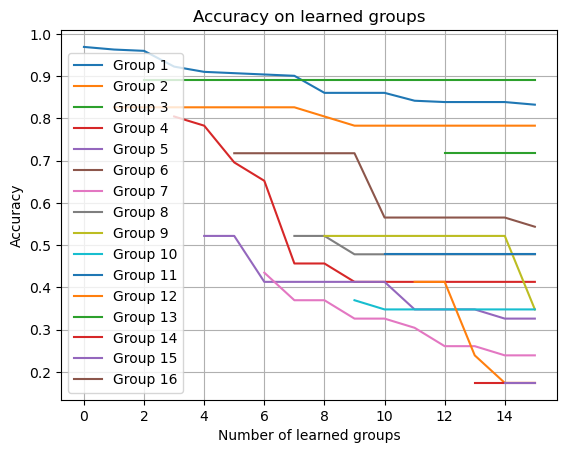

<Axes: title={'center': 'Accuracy on learned groups'}, xlabel='Number of learned groups', ylabel='Accuracy'>

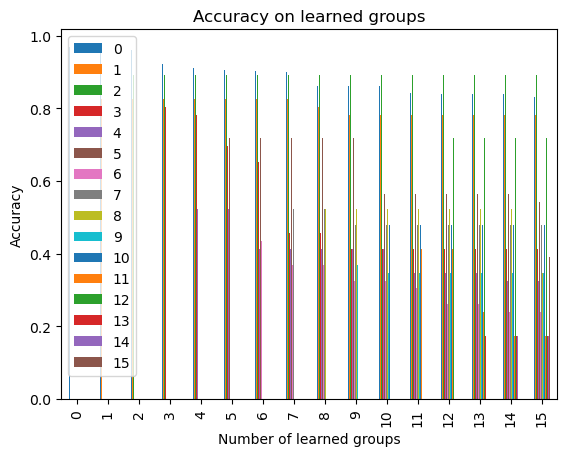

In [5]:
#Figure for accuracy on learned class
df = pd.DataFrame(accuracy_learned_grouped)
df1 = df.replace(np.nan, 0)
df=df.T

fig, ax = plt.subplots()
for i in range(len(class_to_group)):
    ax.plot(list(df.iloc[i]),label=f'Group {i+1}')

ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

ax.grid()
ax.legend()
plt.show()

# Bar plot 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set(xlabel='Number of learned groups', ylabel='Accuracy',
        title='Accuracy on learned groups')

df1.plot(kind='bar', ax=ax)

Partial fit
Score accuracy batch 0:  0.5434782608695652
Score accuracy global:  0.5899209486166008
Memory:  453.3453125 MB
Partial fit
Score accuracy batch 1:  0.5770750988142292
Score accuracy global:  0.5928853754940712
Memory:  460.003125 MB
Partial fit
Score accuracy batch 2:  0.5770750988142292
Score accuracy global:  0.5938735177865613
Memory:  466.6675866168478 MB
Partial fit
Score accuracy batch 3:  0.575098814229249
Score accuracy global:  0.5958498023715415
Memory:  471.98203125 MB
Partial fit
Score accuracy batch 4:  0.5691699604743083
Score accuracy global:  0.5958498023715415
Memory:  436.90347272398844 MB
Partial fit
Score accuracy batch 5:  0.5711462450592886
Score accuracy global:  0.5928853754940712
Memory:  438.67065755208336 MB
Partial fit
Score accuracy batch 6:  0.567193675889328
Score accuracy global:  0.5938735177865613
Memory:  439.00660211267603 MB
Partial fit
Score accuracy batch 7:  0.5612648221343873
Score accuracy global:  0.5958498023715415
Memory:  440.09

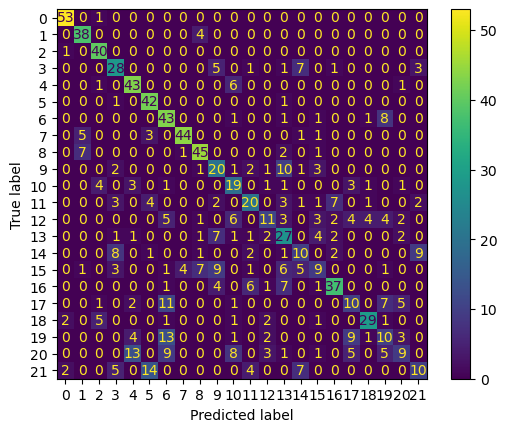

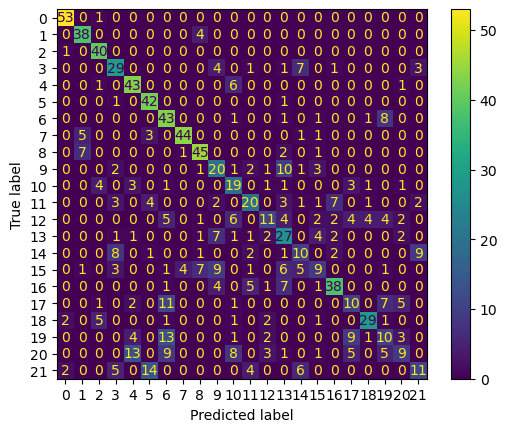

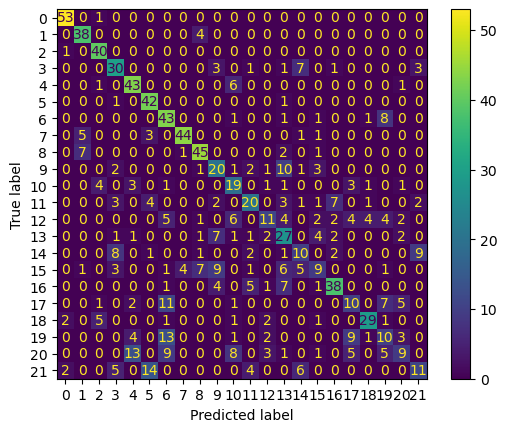

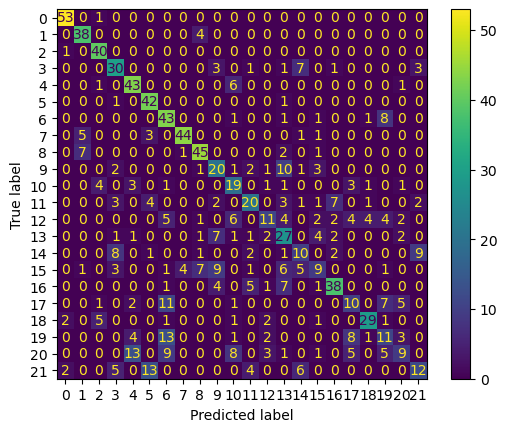

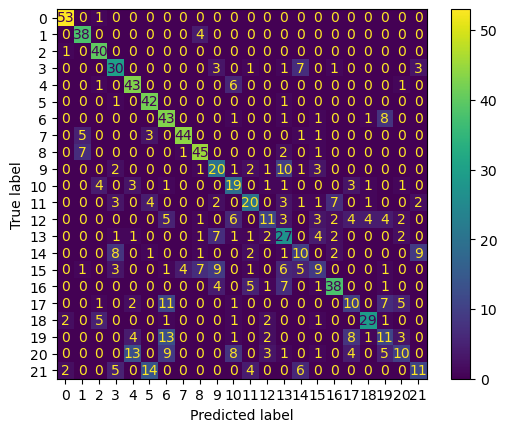

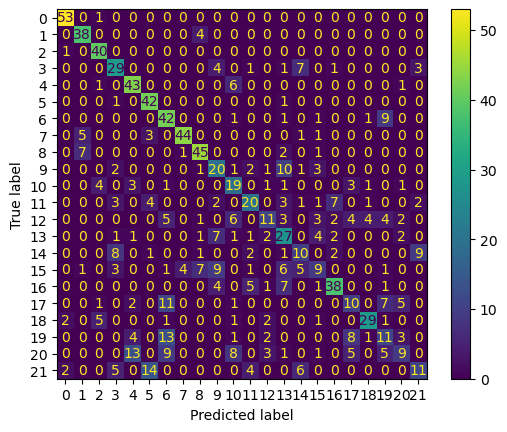

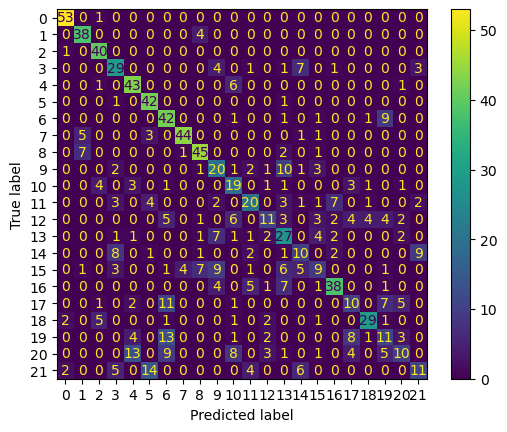

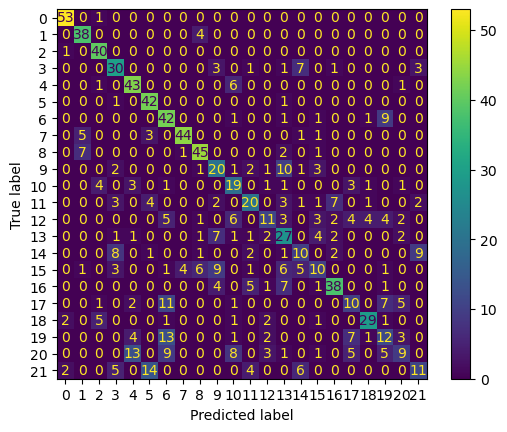

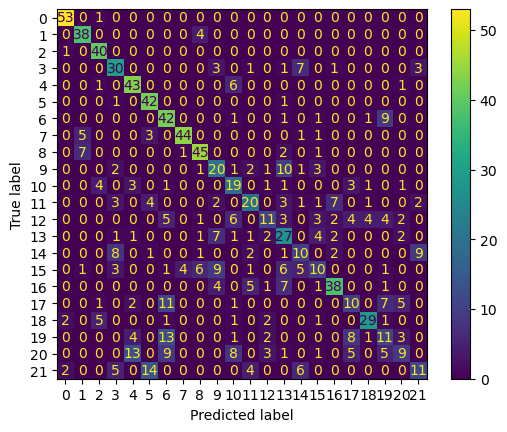

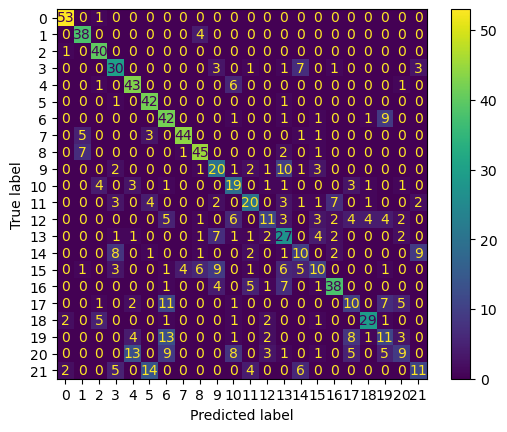

In [6]:
X_train_split_data,y_train_split_data,X_test_split_data,y_test_split_data=loader.split_dataset_data(10,random_state=1)
memory_values = []

for x in range(len(X_train_split_data)):
    mem,res=model.partial_fit_train(X_train_split_data[x],y_train_split_data[x],classes=loader.classes)
    print(f"Score accuracy batch {x}: ",model.score(X_test_split_data[x],y_test_split_data[x]))
    print("Score accuracy global: ",model.score(loader.X_test,loader.y_test))
    print("Memory: ",np.mean(mem),"MB")
    memory_values.append(np.mean(mem))

    y_pred=model.predict(loader.X_test)
    cm = confusion_matrix(loader.y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

model.reset_model()

average_memory = np.mean(memory_values)
print("Average memory usage: ", average_memory,"MB")